# ADA - Homework 2

In [1]:
#Usefull imports
import numpy as np
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import seaborn
%matplotlib inline
import matplotlib.pyplot as plt

## FIRST PART : topuniversities.com

## Plan
1. Get the data from the website
2. Load the data in a dataframe
3. Complete the dataframe with the details pages
4. Compute the best ratio of Faculty Members/Students
5. Compute the best ratio of International Students/Local students
6. Redo the points 4 and 5 for each country
7. Redo the points 4 and 5 for each region
8. Plot the data with bar charts and describe

### 1. Fetch data

In [2]:
#Given an url, get the soup with Beautiful soup
def get_soup_from_url(url):
    r = requests.get(url)
    return BeautifulSoup(r.text, 'html.parser')

We retreived the file from the url : https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508145219316 <br>
This URL was found by using the Postman tracker and looking for the term "file" in the GET request URLs. <br>
The content of this page is a json file with the following data : rank of universities, their name, country, region and related webpage (where we will find the data to compute the ratios)

In [3]:
#Given an url, get the dictionnary of the web page content
def get_dict_from_url(url):
    soup = get_soup_from_url(url)
    return json.loads(soup.text)

In [4]:
top_dict = get_dict_from_url('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508145219316')

### 2-3. Load in DF & Complete with detail page

Keep columns : 
- name : title
- rank : rank_display
- country : country
- region : region
- number of faculty members
- number of students (international and total) <br>

Method : 
- In order to get the name, rank, country and region attributes, we only need to read the dictionnaries in the data retreived from the ranking page
- To have the numbers of Faculty Members and Students along with the number of international in both categories, we need to access the specific page of the university. This is done with the url attribute of the dictionnary. By inspection we found that all these values were the 4 first instances of the class "number". We still need to fetch the outer division with a more general name as some pages lack some information (eg. International Faculty number) so we cannot rely on the order of the numbers in the result of findAll(numbers).

In [5]:
#When we do a findAll on a soup, the ResultSet contains some tags.
#This function let us retreive the int value of a tag
def parse_tag_to_number(to_parse):
    number = 0
    for i in range(len(to_parse)):
        string = to_parse[i].string
        string = string.replace("\n", "").replace(" ","").replace(",", "")
        number = int(string)
    return number

In [6]:
#This function is used to retrieve a number in a soup given the outer division class name.
def fetch_number(soup, class_name):
    div_outer = soup.findAll('div', attrs = {'class' :  class_name})
    nb_tag = div_outer[0].findAll('div', attrs = {'class': 'number'})
    return parse_tag_to_number(nb_tag)

__Note__ :
- 'fs' is short for faculty and students 
- 'il' is short for international and local students

In [7]:
#This functions computes the 2 ratios, first retreive the 3 numbers we need and then round result
def get_ratios(soup):
    nb_faculty = fetch_number(soup, "total faculty")
    nb_student = fetch_number(soup, "total student")
    nb_intl_student = fetch_number(soup, "total inter")
    #We don't take the pourcentage for the fs ratio to match the format of 
    #timeshighereducation data but the il ratio is in pourcentages
    fs_ratio = nb_student/nb_faculty
    il_ratio = nb_intl_student*100/nb_student
    return np.round(fs_ratio,2), np.round(il_ratio,2)

In [8]:
#From the dict we fill the dataframe
def get_df_from_dict(data_dict):
    df = pd.DataFrame(columns = ['university', 'rank', 'country', 'region',
                                'faculty_student_ratio',
                                'international_local_student_ratio'])
    #We keep only the top 200 universities
    for ranking in (data_dict['data'])[:200]:
        #We retreive the specific university website
        university_url = 'https://www.topuniversities.com/'+ ranking['url']
        temp_soup = get_soup_from_url(university_url)
        try:
            fs_ratio, il_ratio = get_ratios(temp_soup)
            df.loc[len(df)] = [ranking['title'], ranking['rank_display'], 
                               ranking['country'], ranking['region'],
                                fs_ratio, il_ratio]
        except IndexError :
            #This is in case the specific university website is 404.
            print('Missing information at : ' +ranking['url'])
    return df

In [9]:
top_df = get_df_from_dict(top_dict)

Missing information at : /universities/new-york-university-nyu


In [10]:
top_df.head()

,university,rank,country,region,faculty_student_ratio,international_local_student_ratio
0,Massachusetts Institute of Technology (MIT),1,United States,North America,3.71,33.59
1,Stanford University,2,United States,North America,3.71,22.74
2,Harvard University,3,United States,North America,5.16,23.48
3,California Institute of Technology (Caltech),4,United States,North America,2.37,28.69
4,University of Cambridge,5,United Kingdom,Europe,3.42,35.69


### 4. Best Staff/Student Ratio
We make the assumption that the best ratio is the higher numerical value, that is to say the less students per staff. We will make the same assumption for International/Local Ratio, the more international students per local student

In [11]:
#This function is used to return the row where the category given is maximised
def get_best_ratio(df, category):
    max_value = max(df[category])
    return df[df[category] == max_value]

In [12]:
top_ss_ratio = get_best_ratio(top_df, 'faculty_student_ratio')
print("The best Staff/Student ratio university according to topuniversities is ") 
top_ss_ratio[['university', 'faculty_student_ratio']]

The best Staff/Student ratio university according to topuniversities is 


,university,faculty_student_ratio
183,Vienna University of Technology,24.76


### 5. Best International/Local Ratio

In [13]:
top_il_ratio =get_best_ratio(top_df, 'international_local_student_ratio')
print("The best international/local ratio university according to topuniversities is ") 
top_il_ratio[['university', 'international_local_student_ratio']]

The best international/local ratio university according to topuniversities is 


,university,international_local_student_ratio
34,London School of Economics and Political Scien...,69.14


### 6. Aggregating by country

In [14]:
# This function returns the maximums of the given category ('faculty_student ratio' or 'international_local_student_ratio')
# for each unique element given by group_criterion ('country' or 'region') 

def get_best_ratios_by_group(df, group_criterion, category):
    result = pd.DataFrame()
    # We only take unique groups into consideration, e.g. {Argentina, Australia, Austria...} for countries
    unique_groups = set(df[group_criterion])
    for group in unique_groups:
        # Get universities from the corresponding group
        univ_from_group = df[df[group_criterion] == group]
        # Pick university with the max in the given category
        best = get_best_ratio(univ_from_group, category)
        result = result.append(best)
    # Sorting by group_criterion for a better presentation of the dataframe :) 
    result = result.sort_values(group_criterion)
    return result[[group_criterion, 'university', category]].set_index(group_criterion)

#### Best faculty/student ratio per country

In [15]:
top_fsratios_country_df = get_best_ratios_by_group(top_df, 'country', 'faculty_student_ratio')
top_fsratios_country_df.head()

,university,faculty_student_ratio
country,,
Argentina,Universidad de Buenos Aires (UBA),7.45
Australia,University of Technology Sydney,18.23
Austria,Vienna University of Technology,24.76
Belgium,Université catholique de Louvain (UCL),19.92
Brazil,Universidade Estadual de Campinas (Unicamp),13.50


#### Best international/local student ratio per country

In [16]:
top_ilratios_country_df = get_best_ratios_by_group(top_df, 'country', 'international_local_student_ratio')
top_ilratios_country_df.head()

,university,international_local_student_ratio
country,,
Argentina,Universidad de Buenos Aires (UBA),22.17
Australia,The University of Melbourne,42.74
Austria,University of Vienna,31.47
Belgium,Vrije Universiteit Brussel (VUB),19.96
Brazil,Universidade Estadual de Campinas (Unicamp),3.64


#### Number of universities in the top-200 per country

In [17]:
### Function that returns a dataframe giving the number of universities per group_criterion (country or region) 
def univ_per_group(df, group_criterion):
    final_df = df.groupby(group_criterion).count().sort_values(['university'], ascending = False)[['university']]
    final_df = final_df.rename(columns = {'university':'universities'})
    return final_df

In [18]:
top_univ_per_country = univ_per_group(top_df, 'country')
top_univ_per_country.head()

,universities
country,
United States,46
United Kingdom,28
Germany,11
Netherlands,10
Australia,9


### 7. Aggregating by region

#### Best faculty/student ratio per region

In [19]:
top_fsratios_region_df = get_best_ratios_by_group(top_df, 'region', 'faculty_student_ratio')
top_fsratios_region_df

,university,faculty_student_ratio
region,,
Africa,University of Cape Town,11.31
Asia,Indian Institute of Technology Delhi (IITD),16.05
Europe,Vienna University of Technology,24.76
Latin America,Universidad de Chile,17.22
North America,University of Washington,22.94
Oceania,University of Technology Sydney,18.23


#### Best international/local student ratio per region

In [20]:
top_ilratios_region_df = get_best_ratios_by_group(top_df, 'region', 'international_local_student_ratio')
top_ilratios_region_df

,university,international_local_student_ratio
region,,
Africa,University of Cape Town,16.97
Asia,The University of Hong Kong,40.71
Europe,London School of Economics and Political Scien...,69.14
Latin America,Universidad de Buenos Aires (UBA),22.17
North America,Carnegie Mellon University,47.81
Oceania,The University of Melbourne,42.74


#### Number of universities in the top 200 per region

In [21]:
top_univ_per_region = univ_per_group(top_df, 'region')
top_univ_per_region

,universities
region,
Europe,89
North America,53
Asia,38
Oceania,11
Latin America,7
Africa,1


### 8. Visualise and describe

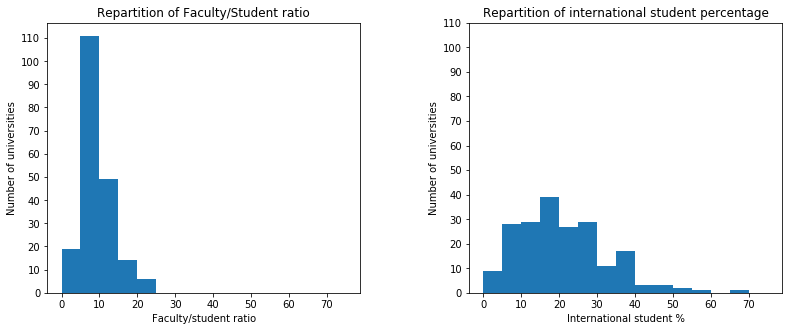

In [22]:
#We decide to plot the number of university having the ratios in bins of 5 (either fs or il)
fig = plt.figure(1)
fig.set_size_inches(12, 2.5)

plt.subplot(121)
plt.hist(top_df['faculty_student_ratio'],bins=range(0,80, 5))
plt.xlabel('Faculty/student ratio')
plt.ylabel('Number of universities')
plt.yticks(range(0,120,10))
plt.title('Repartition of Faculty/Student ratio')

plt.subplot(122)
plt.hist(top_df['international_local_student_ratio'], bins=range(0,80, 5))
plt.xlabel('International student %')
plt.ylabel('Number of universities')
plt.yticks(range(0, 120, 10))
plt.title('Repartition of international student percentage')

plt.subplots_adjust(top=1.5, bottom=0, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
plt.show()

#### Analysis : 
We can see that the number of students per faculty member is not bigger than 25. The majority of universities have 5 to 10 students per faculty member. <br>
Unlike the former ratio, the percentage of international students can go up to 70. Commonly the percentages lies between 5 and 30 %.

## SECOND PART : timeshighereducation.com
For this part we redo the steps of the previous plan.

### 1. Fetch data

In [23]:
times_dict = get_dict_from_url('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')

### 2. Load in DF

In [24]:
#This function is used to parse the strings of the dict to float
def parse_str_to_float(to_parse):
    result = to_parse.replace("%", "")
    return float(result)

In [25]:
times_df = pd.DataFrame(columns = ['university', 'rank', 'country',
                                'faculty_student_ratio',
                                'international_local_student_ratio'])
#We also take only the 200 first rankings
for ranking in (times_dict['data'])[:200]:
    times_df.loc[len(times_df)] = [ranking['name'], ranking['rank'], ranking['location'], 
                                   parse_str_to_float(ranking['stats_student_staff_ratio']), 
                                   parse_str_to_float(ranking['stats_pc_intl_students'])]

#We notice that there is one instance of "Russian federation" and we want it to become "Russia"    
times_df.at[times_df['country'] == "Russian Federation", 'country'] = 'Russia'

In [26]:
times_df.head()

,university,rank,country,faculty_student_ratio,international_local_student_ratio
0,University of Oxford,1,United Kingdom,11.2,38.0
1,University of Cambridge,2,United Kingdom,10.9,35.0
2,California Institute of Technology,=3,United States,6.5,27.0
3,Stanford University,=3,United States,7.5,22.0
4,Massachusetts Institute of Technology,5,United States,8.7,34.0


### 4. Best Staff/Student Ratio

In [27]:
times_ss_ratio = get_best_ratio(times_df, 'faculty_student_ratio')
print("The best Staff/Student ratio university according to timeshighereducation is ") 
times_ss_ratio[['university', 'faculty_student_ratio']]

The best Staff/Student ratio university according to timeshighereducation is 


,university,faculty_student_ratio
99,University of Bonn,77.9


### 5. Best International/Local Ratio

In [28]:
times_il_ratio = get_best_ratio(times_df, 'international_local_student_ratio')
print("The best international/local ratio university according to timeshighereducation is ") 
times_il_ratio[['university', 'international_local_student_ratio']]

The best international/local ratio university according to timeshighereducation is 


,university,international_local_student_ratio
24,London School of Economics and Political Science,71.0


### 6. Group by country

#### Best faculty/student ratio per country

In [29]:
times_fsratios_country_df = get_best_ratios_by_group(times_df, 'country', 'faculty_student_ratio')
times_fsratios_country_df.head()

,university,faculty_student_ratio
country,,
Australia,University of Queensland,35.7
Austria,University of Vienna,20.8
Belgium,Université Libre de Bruxelles,43.4
Canada,McMaster University,24.7
China,Nanjing University,14.2


#### Best international/local student ratio per country

In [30]:
times_ilratios_country_df = get_best_ratios_by_group(times_df, 'country', 'international_local_student_ratio')
times_ilratios_country_df.head()

,university,international_local_student_ratio
country,,
Australia,University of Melbourne,40.0
Austria,University of Vienna,26.0
Belgium,Université Libre de Bruxelles,35.0
Canada,University of British Columbia,29.0
China,Peking University,16.0


#### Number of universities in the top-200 per country

In [31]:
times_univ_per_country = univ_per_group(times_df, 'country')
times_univ_per_country.head()

,universities
country,
United States,62
United Kingdom,31
Germany,20
Netherlands,13
Australia,8


### 7. Group by region

In [32]:
#First we need to get the regions for the Times dataframe
#We extract the unique (country, region) pairs
country_region_df = top_df[['country', 'region']].drop_duplicates()
#Then we match every country in the times_df with their associated region
times_df = times_df.join(country_region_df.set_index('country'), on='country')
# Add manually 'Europe' to the region field of the only Luxembourg university 
#as it is the only NaN 
times_df.at[times_df['country'] == 'Luxembourg', 'region'] = 'Europe'

#### Best faculty/student ratio per region

In [33]:
times_fsratios_region_df = get_best_ratios_by_group(times_df, 'region', 'faculty_student_ratio')
times_fsratios_region_df

,university,faculty_student_ratio
region,,
Africa,University of Cape Town,11.7
Asia,Hong Kong Polytechnic University,26.9
Europe,University of Bonn,77.9
North America,"University of California, Santa Barbara",28.1
Oceania,University of Queensland,35.7


#### Best international/local student ratio per region

In [34]:
times_ilratios_region_df = get_best_ratios_by_group(times_df, 'region', 'international_local_student_ratio')
times_ilratios_region_df

,university,international_local_student_ratio
region,,
Africa,University of Cape Town,18.0
Asia,University of Hong Kong,42.0
Europe,London School of Economics and Political Science,71.0
North America,Carnegie Mellon University,45.0
Oceania,University of Melbourne,40.0


#### Number of universities in the top-200 per region

In [35]:
times_univ_per_region = univ_per_group(times_df, 'region')
times_univ_per_region

,universities
region,
Europe,101
North America,68
Asia,21
Oceania,9
Africa,1


### 8. Visualise and describe

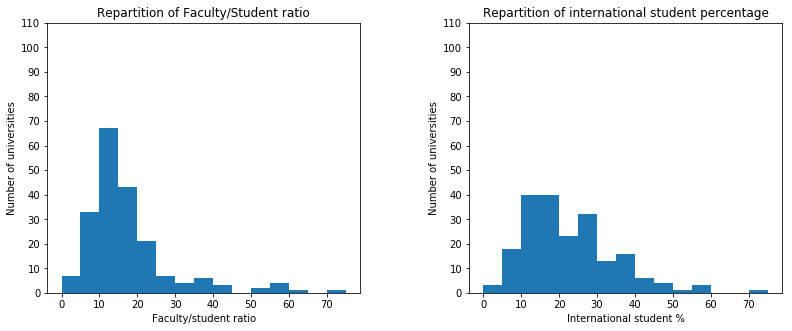

In [36]:
#We decide to plot the number of university having the ratios in bins of 5 (either fs or il)
fig = plt.figure(1)
fig.set_size_inches(12, 2.5)

plt.subplot(121)
plt.hist(times_df['faculty_student_ratio'],bins=range(0,80, 5))
plt.xlabel('Faculty/student ratio')
plt.ylabel('Number of universities')
plt.yticks(range(0,120,10))
plt.title('Repartition of Faculty/Student ratio')

plt.subplot(122)
plt.hist(times_df['international_local_student_ratio'], bins=range(0,80, 5))
plt.xlabel('International student %')
plt.ylabel('Number of universities')
plt.yticks(range(0, 120, 10))
plt.title('Repartition of international student percentage')

plt.subplots_adjust(top=1.5, bottom=0, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
plt.show()

#### Analysis :
Unlike the topuniversities ranking, the peak of Faculty/student ratio is higher, between 10 and 15. The tail is longer too, the maximum value is between 70 and 75. <br>
About the percentage of international student, we are again commonly between 5 and 30%.

## THIRD PART : Unified dataframe
In this part we will merge the 2 former dataframes into one. We must keep the ranking of both rankings and match regarding the university name.

First, in order to keep the ranks and ratios of both websites, we attach the prefix "top" for the data from topuniversities website and "times" for the timeshighereducation website. <br>
Then we have the lists of universities which appear in only one ranking. Those lists are named 'drop_in' + the name of the ranking in which they appear. <br>

In [37]:
tmp_top_df = top_df.rename(columns = {'rank' : 'top_rank', 
                                      'faculty_student_ratio' : 'top_fs_ratio',
                                     'international_local_student_ratio': 'top_il_ratio'})
tmp_times_df = times_df.rename(columns = {'rank' : 'times_rank', 
                                      'faculty_student_ratio' : 'times_fs_ratio',
                                     'international_local_student_ratio': 'times_il_ratio'})

In [38]:
drop_from_top = ['Hanyang University'
, 'University College Dublin'
, 'Universidad de Chile'
, 'University of Bergen'
, 'Alma Mater Studiorum - University of Bologna'
, 'The Hebrew University of Jerusalem'
, 'Chalmers University of Technology'
, 'Tokyo Institute of Technology'
, 'Vienna University of Technology'
, 'Indian Institute of Technology Bombay (IITB)'
, 'Politecnico di Milano'
, 'CentraleSupélec'
, 'Indian Institute of Science (IISc) Bangalore'
, 'Vrije Universiteit Brussel (VUB)'
, 'Yonsei University'
, 'University of Otago'
, 'King Fahd University of Petroleum & Minerals'
, 'Ludwig-Maximilians-Universität München'
, 'Universidad Nacional Autónoma de México  (UNAM)'
, 'Universidade de São Paulo'
, 'Tohoku University'
, 'Universidad de Buenos Aires (UBA)'
, 'Kyushu University'
, 'Pontificia Universidad Católica de Chile (UC)'
, 'Universidad Autónoma de Madrid'
, 'Nagoya University'
, 'Universiti Malaya (UM)'
, 'University of Technology Sydney'
, 'Hokkaido University'
, 'Osaka University'
, 'Korea University'
, 'University of Reading'
, 'Ecole normale supérieure, Paris'
, 'Instituto Tecnológico y de Estudios Superiores de Monterrey'
, 'University of Bath'
, 'Universidade Estadual de Campinas (Unicamp)'
, 'University of Waterloo'
, 'Keio University CEMS MIM'
, 'Indian Institute of Technology Delhi (IITD)'
, 'National Tsing Hua University'
, 'Universitat de Barcelona']

In [39]:
drop_from_times = ['University of Erlangen-Nuremberg'
, 'University of Mannheim'
, 'Rutgers, the State University of New Jersey'
, 'University of Würzburg'
, 'Vrije Universiteit Amsterdam'
, 'University of California, Santa Cruz'
, 'University of Dundee'
, 'Georgetown University'
, 'University of Leicester'
, 'University of Bonn'
, 'Paris-Sorbonne University – Paris 4'
, 'Case Western Reserve University'
, 'University of Miami'
, 'University of Luxembourg'
, 'Paris Sciences et Lettres – PSL Research University Paris'
, 'University of California, Riverside'
, 'Vanderbilt University'
, 'University of Notre Dame'
, 'Paris-Sud University'
, 'Pompeu Fabra University'
, 'Université Libre de Bruxelles'
, 'University of East Anglia'
, 'Tufts University'
, 'Radboud University Nijmegen'
, 'New York University'
, 'Indiana University'
, 'Charité - Universitätsmedizin Berlin'
, 'University of Massachusetts'
, 'University of Arizona'
, 'University of Sussex'
, 'Arizona State University'
, 'University of Cologne'
, 'University of Alabama at Birmingham'
, 'Royal Holloway, University of London'
, 'TU Dresden'
, 'Tilburg University'
, 'University of Gothenburg'
, 'Karolinska Institute'
, 'LMU Munich'
, 'Ulm University'
, 'Northeastern University'
, 'University of Münster']

For a better merge we noticed that we should remove the abbreviations in parenthesis. <br>
Moreover we should remove the "The " prefix as multiple times "The University of ..." is in the other ranking as "University of ..."

In [40]:
for univ in drop_from_top:
    tmp_top_df = tmp_top_df[tmp_top_df['university'] != univ]
for univ2 in drop_from_times:
    tmp_times_df = tmp_times_df[tmp_times_df['university'] != univ2]
print("Do we have the same number of universities : ", (len(tmp_top_df) == len(tmp_times_df)))
print("This number is : ", len(tmp_top_df))

Do we have the same number of universities :  True
This number is :  158


In [41]:
def parse_string(s):
    res = s
    #Some strings don't have any parenthesis or the prefix. We need to handle the exceptions
    try:
        index = s.index('(')
        #We determine the length of the substring to delete
        length_to_delete = len(s) - index
        #If the length_to_delete is greater than the position where we delete,
        #it means that we first have the abbreviation and then full name in parenthesis,
        #we want to keep the full name
        if length_to_delete > index:
            res = s[index+1: len(s)-1]
        else :
        #Here we have the abbreviation in parenthesis and we delete if with the preceding space
            res = s.replace(s[index -1:], '')
        #Now we delete the prefix if the string also contains it
        res = res.replace('The ', '')
        return res
    except ValueError:
        try:
            #This is the case where we only have the prefix to delete
            res = res.replace('The ', '')
            return res
        except ValueError:
            #This is the case where the string is not modified
            return res

Some ranks are similar and are indicated by the equality symbol '=', we want to remove the symbol and convert the ranking from string to int (especially for the FIFTH PART of the homework)

In [42]:
def remove_equality(s):
    res = s.replace("=", "")
    return int(res)

In [43]:
tmp_top_df['university'] = tmp_top_df['university'].map(lambda s : parse_string(s))
tmp_times_df['university'] = tmp_times_df['university'].map(lambda s : parse_string(s))
tmp_top_df['top_rank'] = tmp_top_df['top_rank'].map(lambda s : remove_equality(s))
tmp_times_df['times_rank'] = tmp_times_df['times_rank'].map(lambda s : remove_equality(s))

In [44]:
top = list(tmp_top_df['university'])
times = list(tmp_times_df['university'])

Now we see that we have 22 universities that have small differences in their names. <br>
We sort each list to help us make the permutations indices. Once we have them, we will go through all the universities in the top dataframe and change the university name to the one in times dataframe.

In [45]:
appear_only_in_top = [x for x in top if x not in times]
appear_only_in_times = [x for x in times if x not in top]
appear_only_in_top.sort()
appear_only_in_times.sort()
print("Do we have the same number of universities to match : ", len(top) == len(times))
print("This number is : ", len(appear_only_in_top))

Do we have the same number of universities to match :  True
This number is :  22


In [46]:
permutation_indices = [13,1,16,20,21,2,4,7,5,6,9,3,10,11,12,0,15,8,17,14,18,19]

In [47]:
for i in range(len(appear_only_in_top)):
    current_name = appear_only_in_top[i]
    change_to = appear_only_in_times[permutation_indices[i]]
    tmp_top_df.at[tmp_top_df['university'] == current_name, 'university'] = change_to

Now that we have all correct matching names, we can do the merging and reorder the columns

In [48]:
university_df = tmp_top_df.join(tmp_times_df.set_index(['university', 'country', 'region']),
                                on=['university', 'country', 'region'])

In [49]:
### Reorder columns
university_df = university_df[['university', 'region', 'country', 'top_rank','times_rank', 'top_fs_ratio', 'times_fs_ratio', 'top_il_ratio', 'times_il_ratio']]
university_df.head()

,university,region,country,top_rank,times_rank,top_fs_ratio,times_fs_ratio,top_il_ratio,times_il_ratio
0,Massachusetts Institute of Technology,North America,United States,1,5,3.71,8.7,33.59,34.0
1,Stanford University,North America,United States,2,3,3.71,7.5,22.74,22.0
2,Harvard University,North America,United States,3,6,5.16,8.9,23.48,26.0
3,California Institute of Technology,North America,United States,4,3,2.37,6.5,28.69,27.0
4,University of Cambridge,Europe,United Kingdom,5,2,3.42,10.9,35.69,35.0


## FOURTH PART : Exploratory Analysis
Look for correlations between variables

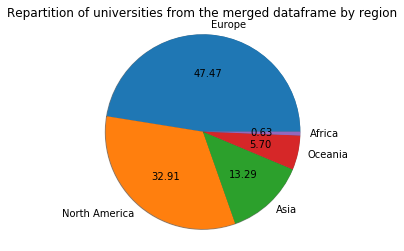

In [50]:
### Display repartition of universities per regions in a pie chart

univ_per_regions = univ_per_group(university_df, 'region')
regions = univ_per_regions.index
universities = univ_per_regions['universities']

plt.pie(universities, labels=regions, shadow=True, radius=5, autopct='%.2f')
plt.axis('equal')
plt.title('Repartition of universities from the merged dataframe by region')

plt.show()

From the plot, we see that the best universities (appearing both in Times and Top Universities) are mostly located in developed regions of the world: Europe, North America, Oceania (universities from Australia and New Zealand)

TopUniversities data are in green while TimesHigherEducation's are in blue


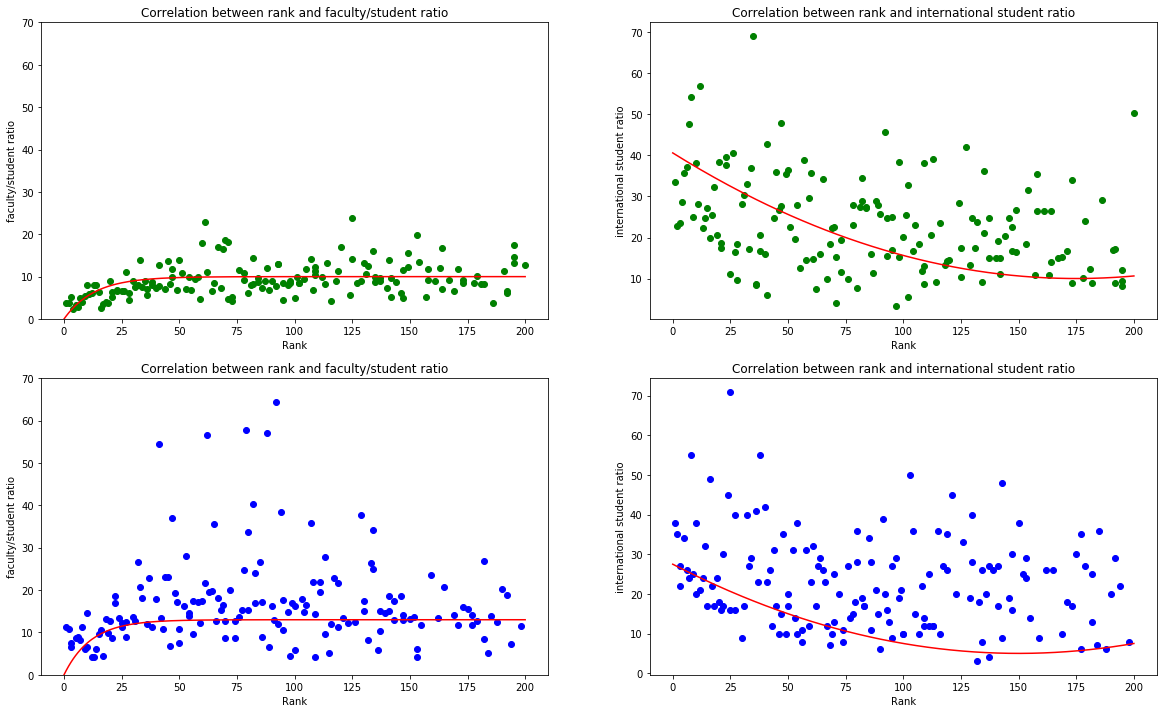

In [51]:
top_rank = university_df['top_rank']
top_fs_ratio = university_df['top_fs_ratio']
top_il_ratio = university_df['top_il_ratio']
times_rank = university_df['times_rank']
times_fs_ratio = university_df['times_fs_ratio']
times_il_ratio = university_df['times_il_ratio']

fig = plt.figure(1)
fig.set_size_inches(20,12)

plt.subplot(221)
plt.plot(top_rank.values, top_fs_ratio.values, 'ro', color = 'g')
plt.title('Correlation between rank and faculty/student ratio')
plt.xlabel('Rank')
plt.ylabel('faculty/student ratio')
plt.gca().set_ylim([0,70])
x1 = np.linspace(0,200,200)
y1 = 10 - pow(10, (1-(x1/30)))
plt.plot(x1,y1, color='red')

plt.subplot(222)
plt.plot(top_rank.values, top_il_ratio.values, 'ro', color = 'g')
plt.title('Correlation between rank and international student ratio')
plt.xlabel('Rank')
plt.ylabel('international student ratio')
plt.plot(x1, 10+pow(x1-175, 2)/1000, color='r')

plt.subplot(223)
plt.plot(times_rank.values, times_fs_ratio.values, 'ro', color = 'b')
plt.title('Correlation between rank and faculty/student ratio')
plt.xlabel('Rank')
plt.ylabel('faculty/student ratio')
plt.gca().set_ylim([0,70])
y3 = 13 - pow(13, (1-(x1/30)))
plt.plot(x1, y3, color='red')

plt.subplot(224)
plt.plot(times_rank.values, times_il_ratio.values, 'ro', color='b')
plt.title('Correlation between rank and international student ratio')
plt.xlabel('Rank')
plt.ylabel('international student ratio')
plt.plot(x1, 5+pow(x1-150, 2)/1000, color='r')


print('TopUniversities data are in green while TimesHigherEducation\'s are in blue')
plt.show()

Those graphs represents the eventual correlations existing between the rank of an university and the different ratios. The red curves are arbitrary and just here to show the general behaviour of the points' distributions since it's not very clear and obvious.
From those graphs we can make two observations: 
1. The faculty/student ratio is not very much corrolated to the ranks except when this one is inferior to 25. At this point we see in both ranking that the ratio tends to fall down when arriving at the top of the rankings.
2. The international student ratio on the contrary seems to go down with the ranking, even if its distribution is way more heterogeneous. Once more, one can see that when the rank is inferior to 25, the ratio tends to be higher than the usual.

So now we can conclude on the correlations of the ratios with the rank of a university and use it in the next part to find the best university by using as criterions the rank, and the 2 ratios.

## FIFTH PART : Best university

We used the following criteria to choose "our" best university:

    1. It must appear in both websites -> thus appear in the merged dataframe from PART THREE.
    2. Its rank must be below 25 in both websites 
    3. The university must have a good international/local ratio (suggesting the reputation of the university is internationally known and students want to go there)
    4. The university must have a small student/faculty ratio (suggesting there are an important number of faculty members to "supervise" the students)
    
For steps 3. and 4., we compute, for each university found in steps 1. and 2., the sum of international/local (I/L) ratio from both sites minus the sum of student/faculty (S/F) ratio from both sites: 

$$ ({I/L Ratio}_{times} + {I/L Ratio}_{topUniversities}) - ({S/F Ratio}_{times} + {S/F Ratio}_{topUniversities}) $$


Finally we pick the university with the maximum of this calculus to be the best university 

In [52]:
### Step 1 already done in PART THREE, we use university_df
### Step 2
top25_times_df = university_df[university_df['times_rank'] <= 25]
top25_both_df = top25_times_df[university_df['top_rank'] <= 25]
### Step 3 and 4
top25_both_df['score'] = top25_both_df['top_il_ratio'] + top25_both_df['times_il_ratio'] - (top25_both_df['top_fs_ratio'] + top25_both_df['times_fs_ratio'])
### Get university with maximum value
best_university = top25_both_df.loc[top25_both_df['score'].idxmax()]
print("Best university (following our criteria and after EPFL obviously) is: ")
best_university[['university', 'score']]

Best university (following our criteria and after EPFL obviously) is: 


/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


university    Imperial College London
score                           93.87
Name: 7, dtype: object